# Denoising via Deep Learning Models

We now evaluate the effectiveness of deep learning as a tool for both denoising
and feature extraction. 

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [5]:
from preprocess import load_fixedSize, returnEventDistribution, preprocessInputs

### Analyze the data. Consider events ordered by the number of samples we have.
eventDistribution = returnEventDistribution('MU')
print(eventDistribution)

### Where X represents input EEG data, Y represents OHE MNIST labels, and Y_raw
# represents the raw MNIST labels.
feature_size = 476
X, Y, Y_raw = load_fixedSize(feature_size, 'MU')
X = preprocessInputs(X)
feature_size = X.shape[1]
print('Feature Size: ', feature_size)

OrderedDict([(476, 51272), (460, 44432), (459, 32815), (493, 18504), (442, 9584), (510, 3308), (425, 2208), (527, 728), (408, 312), (544, 224), (561, 52), (474, 40), (461, 32), (438, 16), (468, 16), (478, 16), (457, 12), (472, 12), (497, 12), (470, 12), (467, 12), (492, 12), (473, 12), (464, 12), (479, 12), (480, 12), (465, 12), (490, 12), (456, 12), (446, 8), (506, 8), (495, 8), (463, 8), (444, 8), (477, 8), (462, 8), (485, 8), (475, 8), (454, 8), (491, 8), (443, 8), (484, 8), (471, 8), (452, 4), (486, 4), (449, 4), (578, 4), (482, 4), (508, 4), (458, 4), (488, 4), (483, 4), (469, 4), (455, 4), (440, 4), (439, 4), (501, 4), (536, 4), (612, 4), (450, 4), (481, 4), (453, 4), (487, 4), (448, 4), (524, 4), (445, 4), (451, 4), (498, 4), (509, 4)])
Preprocessing MU dataset...

Preprocessing complete.
Inputs shape: (51272, 476) || Labels shape: (51272, 10)
Feature Size:  476


Once again, we visualize the data before training our autoencoder model.

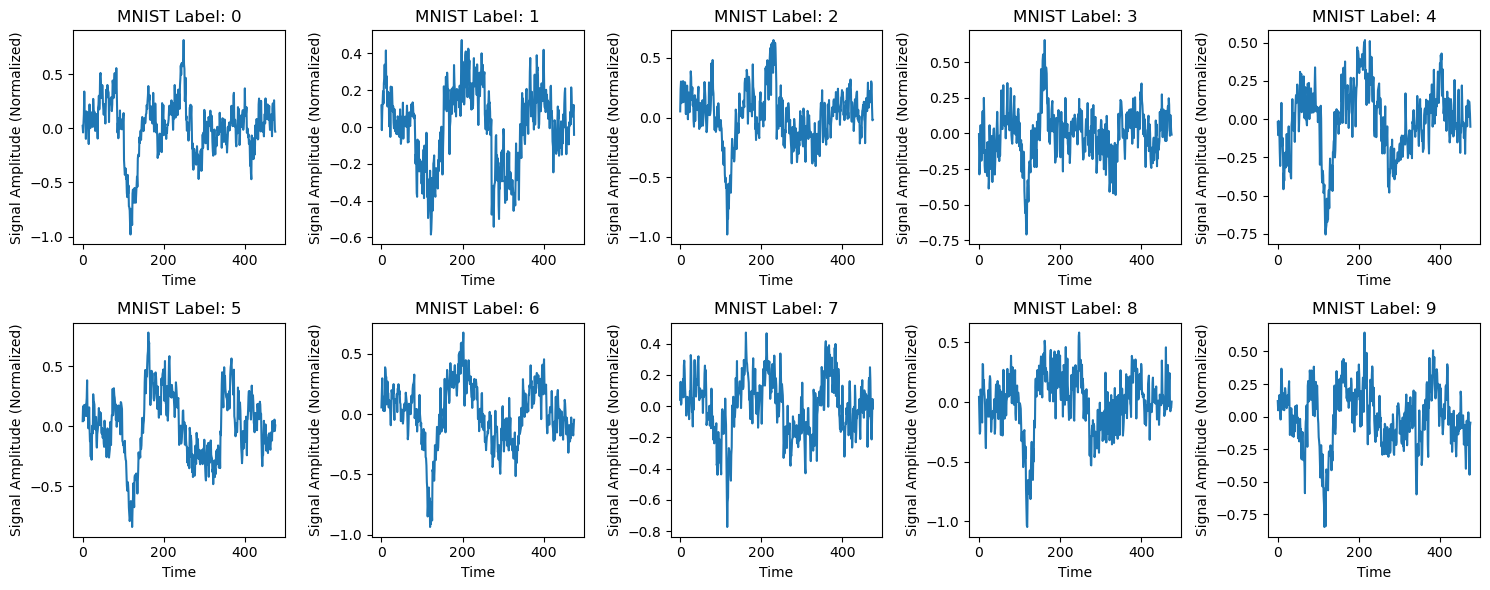

In [6]:
## Sanity Check on Data. 
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np

averaged_samples = defaultdict(list)

for signal, label in zip(X, Y_raw):
    averaged_samples[label].append(signal)

# Calculate the average of each label. This is the average signal for each label.
for label, signals in averaged_samples.items():
    averaged_signal = np.mean(signals, axis=0)
    averaged_samples[label] = averaged_signal

# Plot the averaged signals
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()
for i in range(10):
    averaged_signal, label = averaged_samples[i], i
    axes[i].plot(averaged_signal)
    axes[i].set_title(f"MNIST Label: {label}")
    axes[i].set_xlabel("Time")
    axes[i].set_ylabel("Signal Amplitude (Normalized)")

plt.tight_layout()
plt.show()

Here our train-test split will look different since the labels are the data itself.
We consequently try to regenerate the images as best as we can, but this is also 
mainly focused on feature extraction.

In [7]:
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset

# Split the data into train-validation-testing sets
X_train, X_val_test = train_test_split(X, test_size=0.2, random_state=42)
X_val, X_test = train_test_split(X_val_test, test_size=0.5, random_state=42)

# Convert the data into PyTorch tensors
X_train_tensor = torch.tensor(X_train)
X_val_tensor = torch.tensor(X_val)
X_test_tensor = torch.tensor(X_test)

# Create TensorDatasets for train-validation-testing sets
train_dataset = TensorDataset(X_train_tensor)
val_dataset = TensorDataset(X_val_tensor)
test_dataset = TensorDataset(X_test_tensor)

# Create Dataloaders for train-validation-testing sets
ae_train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
ae_val_dataloader = DataLoader(val_dataset, batch_size=32)
ae_test_dataloader = DataLoader(test_dataset, batch_size=32)


We define our autoencoder model and train it to reconstruct data.

In [8]:
from models.autoencoder import Autoencoder
from torch import optim, nn

### Model Setup
ae_model = Autoencoder(feature_size)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Running on", device)
ae_model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(ae_model.parameters(), lr=0.0001)

Running on cuda:0


In [10]:
### Training Loop
num_epochs = 50
ae_epoch_train_losses = []
ae_epoch_val_losses   = []

for epoch in range(num_epochs):
    epoch_train_loss = 0
    epoch_val_loss   = 0
    epoch_accuracy   = 0

    ## Training
    ae_model.train()
    for batchX in ae_train_dataloader:
        # Forward pass
        batchX = batchX[0].to(device)
        outputs = ae_model(batchX).to(device)
        
        # Backward pass
        loss = criterion(outputs, batchX)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        epoch_train_loss += loss.item()
    
    ## Validation
    ae_model.eval()
    with torch.no_grad():
        for batchX in ae_val_dataloader:
            batchX = batchX[0].to(device)
            outputs = ae_model(batchX).to(device)
            loss = criterion(outputs, batchX)
            epoch_val_loss += loss.item()

    # Save and print losses
    epoch_train_loss /= len(ae_train_dataloader)
    epoch_val_loss   /= len(ae_val_dataloader)

    ae_epoch_train_losses.append(epoch_train_loss)
    ae_epoch_val_losses.append(epoch_val_loss)
    
    print(f"Epoch {epoch + 1} Training loss: {epoch_train_loss} || Validation loss: {epoch_val_loss}")

Epoch 1 Training loss: 46.352795026603616 || Validation loss: 55.3464525353094
Epoch 2 Training loss: 45.143221502557004 || Validation loss: 54.89144697248565
Epoch 3 Training loss: 41.161311549813064 || Validation loss: 60.41762864959907
Epoch 4 Training loss: 39.61327754242372 || Validation loss: 52.086205464712585
Epoch 5 Training loss: 37.8587365611667 || Validation loss: 50.498664216225194
Epoch 6 Training loss: 36.62284410539172 || Validation loss: 52.94117106562076
Epoch 7 Training loss: 38.51845024007717 || Validation loss: 50.48663134604507
Epoch 8 Training loss: 34.21014001849289 || Validation loss: 50.49867299476766
Epoch 9 Training loss: 32.757998767769465 || Validation loss: 49.47589175301309
Epoch 10 Training loss: 34.82967593628977 || Validation loss: 47.714057910516395
Epoch 11 Training loss: 32.083227414236795 || Validation loss: 46.83638328647021
Epoch 12 Training loss: 32.7565212398535 || Validation loss: 50.826519664029895
Epoch 13 Training loss: 33.16851966726985 |

KeyboardInterrupt: 

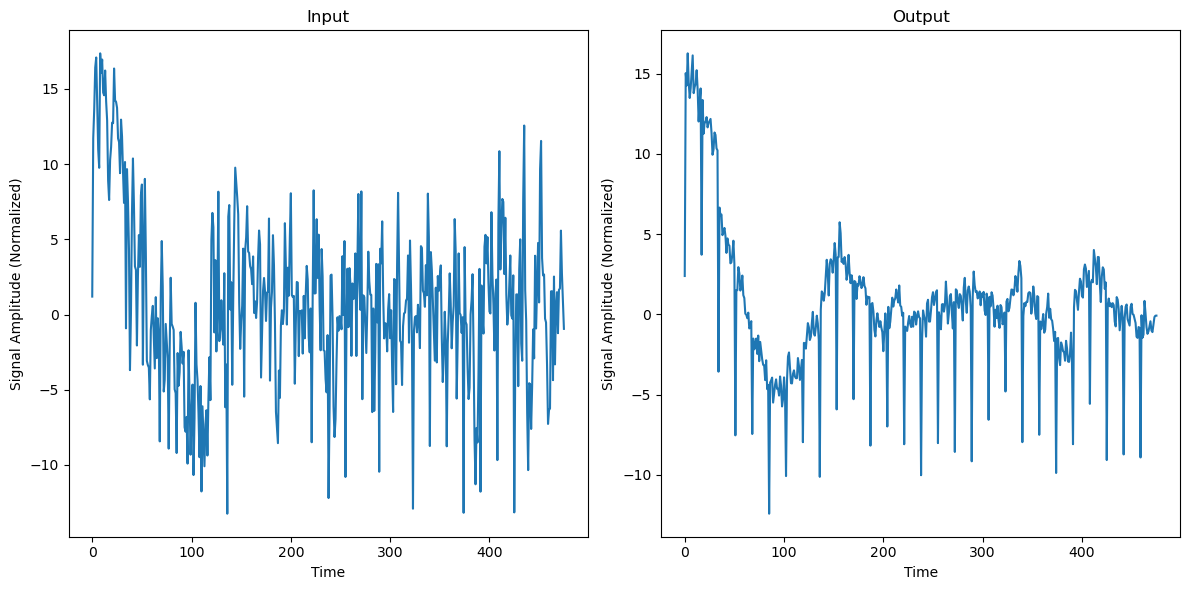

In [12]:
import matplotlib.pyplot as plt

# Set the autoencoder model to evaluation mode
ae_model.eval()

# Select a random sample from the test dataset
sample_index = 0  # Change this index to visualize different samples
sample_input = X_test_tensor[sample_index].unsqueeze(0).to(device)

# Pass the sample through the autoencoder
sample_output = ae_model(sample_input)

# Convert the tensors to numpy arrays
input_array = sample_input.cpu().detach().numpy()
output_array = sample_output.cpu().detach().numpy()

# Reshape the arrays to match the original shape
input_array = input_array.reshape(-1, feature_size)
output_array = output_array.reshape(-1, feature_size)

# Plot the input and output side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the input
axes[0].plot(input_array[0])
axes[0].set_title("Input")
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Signal Amplitude (Normalized)")

# Plot the output
axes[1].plot(output_array[0])
axes[1].set_title("Output")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Signal Amplitude (Normalized)")

plt.tight_layout()
plt.show()

### Baseline Re-Running

We now re-run our baselines and compare their performance to the original baselines
on the original data.

In [13]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np

# Split the data into train, validation, and test sets.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25, random_state=42) 
Y_train, Y_val, Y_test = np.float32(Y_train), np.float32(Y_val), np.float32(Y_test)

# Convert the data to PyTorch tensors.
X_train_tensor, X_val_tensor, X_test_tensor = torch.from_numpy(X_train), torch.from_numpy(X_val), torch.from_numpy(X_test)
Y_train_tensor, Y_val_tensor, Y_test_tensor = torch.from_numpy(Y_train), torch.from_numpy(Y_val), torch.from_numpy(Y_test)

# Create TensorDatasets for train and test sets.
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
val_dataset   = TensorDataset(X_val_tensor, Y_val_tensor)
test_dataset  = TensorDataset(X_test_tensor, Y_test_tensor)

# Create DataLoader for train and test sets.
batch_size = 8
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [14]:
from models.baseline import mlp_Baseline
from torch import optim, nn

### Model Setup
mlp_model = mlp_Baseline(feature_size, 10)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Running on", device)
mlp_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)

Running on cuda:0


In [16]:
### Training Loop
num_epochs = 10
mlp_epoch_train_losses = []
mlp_epoch_val_losses   = []
mlp_epoch_accuracies   = []

for epoch in range(num_epochs):
    epoch_train_loss = 0
    epoch_val_loss   = 0
    epoch_accuracy   = 0

    ## Training
    mlp_model.train()
    for (batchX, batchY) in train_dataloader:
        # Forward pass
        outputs = mlp_model(batchX.to(device)).to(device)
        
        # Backward pass
        loss = criterion(outputs, batchY.to(device))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        epoch_train_loss += loss.item()
    
    ## Validation
    mlp_model.eval()
    with torch.no_grad():
        for (batchX, batchY) in val_dataloader:
            outputs = mlp_model(batchX.to(device)).to(device)
            loss = criterion(outputs, batchY.to(device))
            epoch_val_loss += loss.item()
            if np.argmax(outputs.detach().cpu().numpy()) == np.argmax(batchY.detach().cpu().numpy()):
                epoch_accuracy += 1

    # Save and print losses
    epoch_train_loss /= len(train_dataloader)
    epoch_val_loss   /= len(val_dataloader)
    epoch_accuracy   /= len(val_dataloader)

    mlp_epoch_train_losses.append(epoch_train_loss)
    mlp_epoch_val_losses.append(epoch_val_loss)
    mlp_epoch_accuracies.append(epoch_accuracy)
    
    print(f"Epoch {epoch + 1} Training loss: {epoch_train_loss} || Validation loss: {epoch_val_loss} || Accuracy: {epoch_accuracy}")

Epoch 1 Training loss: 2.311089533942476 || Validation loss: 2.3023110103681566 || Accuracy: 0.10842433697347893
Epoch 2 Training loss: 2.3030018164847457 || Validation loss: 2.3022029399871826 || Accuracy: 0.10452418096723869
Epoch 3 Training loss: 2.3024251307290604 || Validation loss: 2.302115023043152 || Accuracy: 0.10920436817472699
Epoch 4 Training loss: 2.3024345126179315 || Validation loss: 2.3024391716988335 || Accuracy: 0.10920436817472699
Epoch 5 Training loss: 2.302390513975547 || Validation loss: 2.3022332303051645 || Accuracy: 0.10452418096723869


KeyboardInterrupt: 

In [17]:
from models.baseline import rnn_Baseline

### Model Setup
rnn_model = rnn_Baseline(64, 10)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Running on", device)
rnn_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(rnn_model.parameters(), lr=0.001)

Running on cuda:0


In [18]:
### Training Loop
num_epochs = 10
rnn_epoch_train_losses = []
rnn_epoch_val_losses   = []
rnn_epoch_accuracies   = []

for epoch in range(num_epochs):
    epoch_train_loss = 0
    epoch_val_loss   = 0
    epoch_accuracy   = 0

    ## Training
    rnn_model.train()
    for (batchX, batchY) in train_dataloader:
        # Forward pass
        outputs = rnn_model(batchX.to(device)).to(device)

        # Backward pass
        loss = criterion(outputs, batchY.to(device))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        epoch_train_loss += loss.item()
    
    ## Validation
    rnn_model.eval()
    with torch.no_grad():
        for (batchX, batchY) in val_dataloader:
            outputs = rnn_model(batchX.to(device)).to(device)
            loss = criterion(outputs, batchY.to(device))
            epoch_val_loss += loss.item()

            if np.argmax(outputs.detach().cpu().numpy()) == np.argmax(batchY.detach().cpu().numpy()):
                epoch_accuracy += 1

    # Save and print losses
    epoch_train_loss /= len(train_dataloader)
    epoch_val_loss   /= len(val_dataloader)
    epoch_accuracy   /= len(val_dataloader)

    rnn_epoch_train_losses.append(epoch_train_loss)
    rnn_epoch_val_losses.append(epoch_val_loss)
    rnn_epoch_accuracies.append(epoch_accuracy)
    
    print(f"Epoch {epoch + 1} Training loss: {epoch_train_loss} || Validation loss: {epoch_val_loss} || Accuracy: {epoch_accuracy}")

Epoch 1 Training loss: 2.310712258330993 || Validation loss: 2.3087813701718907 || Accuracy: 0.00858034321372855
Epoch 2 Training loss: 2.290618525032444 || Validation loss: 2.3177575120315907 || Accuracy: 0.014040561622464899
Epoch 3 Training loss: 2.252195990184788 || Validation loss: 2.3389072513989464 || Accuracy: 0.014820592823712949
Epoch 4 Training loss: 2.2012962097310798 || Validation loss: 2.3667929211570393 || Accuracy: 0.014820592823712949
Epoch 5 Training loss: 2.130552602756538 || Validation loss: 2.4047617574749798 || Accuracy: 0.0171606864274571
Epoch 6 Training loss: 2.0551788867666767 || Validation loss: 2.4551691251128402 || Accuracy: 0.01638065522620905
Epoch 7 Training loss: 1.9684846800128681 || Validation loss: 2.521635126305073 || Accuracy: 0.01638065522620905
Epoch 8 Training loss: 1.8845887860778217 || Validation loss: 2.5980252082373907 || Accuracy: 0.0171606864274571
Epoch 9 Training loss: 1.803288771005205 || Validation loss: 2.6509820462760985 || Accuracy: